# ICLR Workshop Challenge #1: CGIAR Computer Vision for Crop Disease

Amritha Musipatla and Grisam Shah  
CU_sm3773_gvs2110

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports and packages

In [24]:
import os
import csv
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Package to show progress bars on loops
from progressbar import ProgressBar, Percentage, Bar

from fastai.vision import *

## Data Observations

Check class distribution in training data.

stem_rust :	 376
healthy_wheat :	 142
leaf_rust :	 358

Total train images:	 876


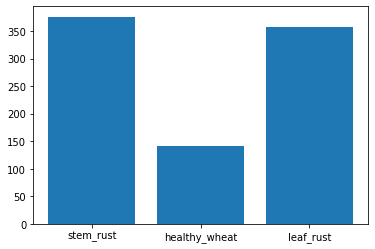

In [22]:
base_dir = "data/"
train_dir = "data/train/"
test_dir = "data/test"

class_dist = {}
total_train = 0

for subdir, dirs, ims in os.walk(train_dir):
    img_list = os.listdir(subdir) 
    number_files = len(img_list)
    
    if (subdir != train_dir):
        print(subdir.split('/')[-1],":\t",number_files)
        total_train = total_train + number_files
        class_dist[subdir.split('/')[-1]] = number_files

print("\nTotal train images:\t", total_train)
    
plt.bar(range(len(class_dist)), class_dist.values(), align='center')
plt.xticks(range(len(class_dist)), list(class_dist.keys()))

plt.show()

Display examples of each class:

stem_rust


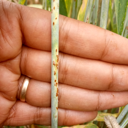

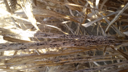

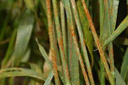

healthy_wheat


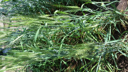

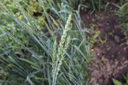

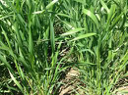

leaf_rust


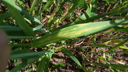

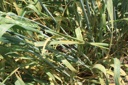

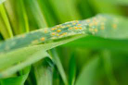

In [45]:
for subdir, dirs, ims in os.walk(train_dir):
    if (subdir != train_dir):
        # Choose random files
        img_list = os.listdir(subdir) 
        number_files = len(img_list)
        img_nums = random.sample(range(number_files), 3)
        print(subdir.split('/')[-1])
        for i in img_nums:
            image = PIL.Image.open(subdir+'/'+img_list[i])
            image.thumbnail([128,128])
            display(image)
            #plt.imshow(np.asarray(image))
            


## Preprocessing

In this section we format the given train and test image sets to standard form.

In [3]:
base_dir = "data/"
train_dir = "data/train/"
test_dir = "data/test"

# Convert all images to jpg
for subdir, dirs, ims in os.walk(train_dir):
    for im in ims:
        im_path = subdir + os.sep + im
        if im.endswith(".jfif"): 
            im_name, ext = os.path.splitext(im_path)
            im_convert = im_name + ".jpg"
            print(os.path.join(im_path))
            try:
                Image.open(im_path).save(im_convert)
                os.remove(im_path)
            except IOError:
                print("cannot convert", im_path)
            continue
        else:
            continue
            
for subdir, dirs, ims in os.walk(test_dir):
    for im in ims:
        im_path = subdir + os.sep + im
        if im.endswith(".jfif"): 
            im_name, ext = os.path.splitext(im_path)
            im_convert = im_name + ".jpg"
            print(os.path.join(im_path))
            try:
                Image.open(im_path).save(im_convert)
                os.remove(im_path)
            except IOError:
                print("cannot convert", im_path)
            continue
        else:
            continue

Format images as array and reshape to standard size:

In [4]:
def image_to_array(image_path, default_size):
    try:
        im = Image.open(image_path)
        if im is not None:
            out = im.resize(default_size)
            return img_to_array(out)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Create training data from folder.

In [5]:
data = ImageDataBunch.from_folder(base_dir, test='test', size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (876 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: data;

Valid: LabelList (537 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
stem_rust,stem_rust,stem_rust,stem_rust,stem_rust
Path: data;

Test: LabelList (610 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: data

Confirm image integrity by plotting.

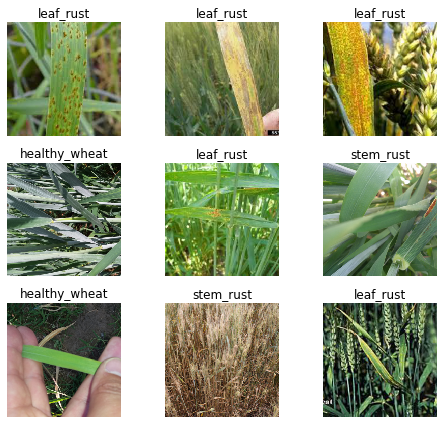

In [6]:
data.show_batch(rows=3, figsize=(7,6))

## Setting up NN model

Create the model: 

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/amritha/.cache/torch/checkpoints/resnet50-19c8e357.pth


## Training Model

In [8]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.317462,0.481181,0.137803,13:25
1,0.892986,0.182811,0.050279,14:07
2,0.655227,0.090805,0.027933,43:34
3,0.498324,0.072407,0.014898,13:03


## Measuring Model

Set up classification interpretation object:

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

Observe "most incorrect".

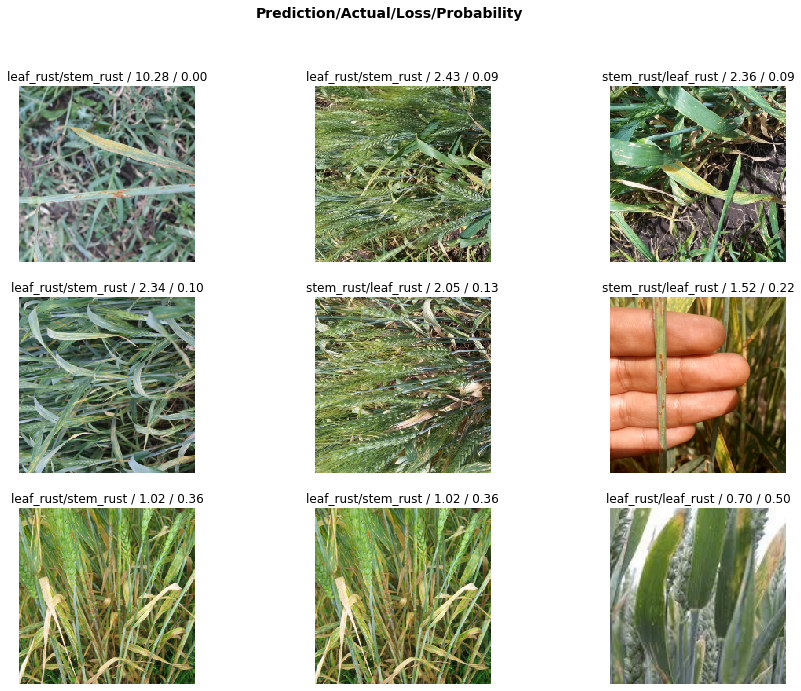

In [10]:
interp.plot_top_losses(9, figsize=(15,11))

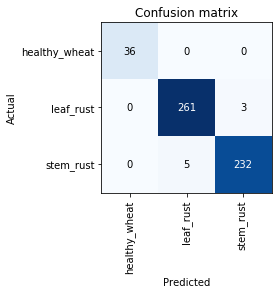

In [11]:
interp.most_confused(min_val=2)
interp.plot_confusion_matrix()

## Making Predictions

Formatting test data:

In [13]:
df = pd.DataFrame(columns=['ID','healthy_wheat','leaf_rust','stem_rust'])
num = len(learn.data.test_ds)

for i in range(num):
    print(i)
    filename = str(learn.data.test_ds.items[i]).split('/')[-1].split('.')[0]
    pred = learn.predict(learn.data.test_ds[i][0])
    df2 = pd.DataFrame({"ID": filename,
                        "healthy_wheat": [pred[2][0].item()],
                        "stem_rust": [pred[2][2].item()],
                        "leaf_rust": [pred[2][1].item()]
                        })
    df = df.append(df2, sort=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Print predictions to submission format file. 

In [14]:
print(df)
df.to_csv('submission4.csv')

        ID  healthy_wheat  leaf_rust     stem_rust
0   1WP5MJ       0.784769   0.024684  1.905468e-01
0   C3LIDU       0.000986   0.973864  2.514931e-02
0   OS8FB2       0.002205   0.000577  9.972172e-01
0   NS8DVC       0.303944   0.544625  1.514310e-01
0   2G71YU       0.027024   0.790750  1.822260e-01
..     ...            ...        ...           ...
0   Y7VVJU       0.997884   0.002107  9.053480e-06
0   D6TACK       0.594895   0.295464  1.096407e-01
0   UIPPYH       0.000551   0.000005  9.994439e-01
0   BE0SDD       0.000005   0.999995  1.178997e-07
0   UGQ06J       0.023502   0.026723  9.497749e-01

[610 rows x 4 columns]
